In [140]:
# !pip install pandas_datareader

In [141]:
import math
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas_datareader as pdr
from datetime import datetime, timedelta

In [142]:
#Get the stock
ticker = 'SBUX'
stock ="Starbucks Corporation"
#  here we will use n  days historical data to predict next day closing
ts_points = 120
# train_data[0:60,0]  

today = datetime.today()
# start_date ='2016-01-01'
start_date = (today - timedelta(days=5*365) ).strftime('%Y-%m-%d')

# end_date   = today.strftime('%Y-%m-%d')
end_date = (today - timedelta(days=62) ).strftime('%Y-%m-%d')

stock_df = pdr.DataReader(ticker, data_source="yahoo", start=start_date, end=end_date)

In [143]:
# Date is an index but to be sure , let's sort
stock_df = stock_df.sort_index(ascending=True)
stock_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-10-26,53.840000,53.360001,53.599998,53.630001,5817800.0,48.670071
2016-10-27,53.830002,53.130001,53.599998,53.590000,7900000.0,48.633774
2016-10-28,53.840000,53.110001,53.650002,53.529999,6620300.0,48.579315
2016-10-31,53.700001,53.060001,53.700001,53.070000,9142500.0,48.161865
2016-11-01,53.209999,52.090000,53.139999,52.500000,15425800.0,47.644581
...,...,...,...,...,...,...
2021-08-18,116.739998,115.599998,116.279999,115.680000,4520500.0,115.680000
2021-08-19,115.070000,113.610001,114.510002,114.320000,5317100.0,114.320000
2021-08-20,115.000000,113.660004,113.980003,114.629997,3485400.0,114.629997


In [144]:
# check for nulls
stock_df.isna().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [145]:
# Get shape
stock_df.shape

(1215, 6)

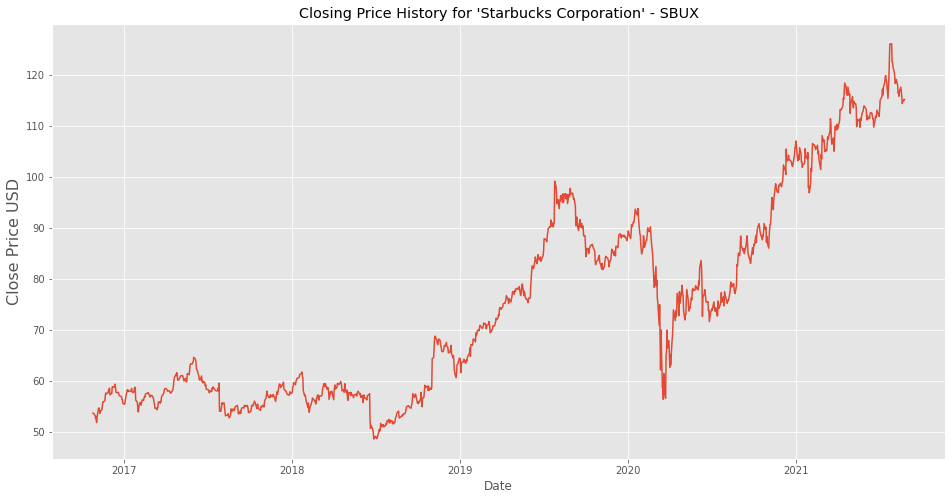

In [146]:
# Visualize closing price history
plt.figure(figsize=(16,8))
plt.title (f"Closing Price History for '{stock}' - {ticker}")
plt.plot(stock_df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD', fontsize=16)
plt.savefig('static/Images/his_'+ticker+'.png')
plt.show()

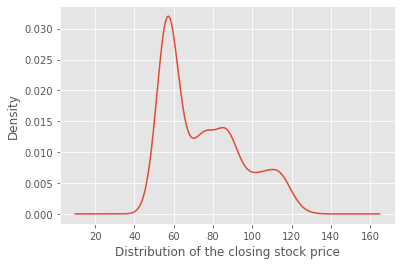

In [147]:
stock_df['Close'].plot.density()
plt.xlabel('Distribution of the closing stock price')
plt.savefig('static/Images/den_'+ticker+'.png')
plt.show()

In [148]:
# DF with only close
TSdata_df = stock_df.filter(['Close'])
TSdata_df


,Close
Date,
2016-10-26,53.630001
2016-10-27,53.590000
2016-10-28,53.529999
2016-10-31,53.070000
2016-11-01,52.500000
...,...
2021-08-18,115.680000
2021-08-19,114.320000
2021-08-20,114.629997


In [149]:
TSdata_arr = TSdata_df.values # this creates an array of Close Price
TSdata_arr

array([[ 53.63000107],
       [ 53.59000015],
       [ 53.52999878],
       ...,
       [114.62999725],
       [115.15000153],
       [115.08000183]])

In [150]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np

# ADF Test
result = adfuller(TSdata_arr, autolag='AIC')

print('ADF Statistic: %f' % result[0])

print('p-value: %f' % result[1])

print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -0.289778
p-value: 0.926940
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Failed to Reject Ho - Time Series is Non-Stationary


In [151]:
df2 = TSdata_df['Close'].diff().dropna().to_frame()
df2

,Close
Date,
2016-10-27,-0.040001
2016-10-28,-0.060001
2016-10-31,-0.459999
2016-11-01,-0.570000
2016-11-02,0.480000
...,...
2021-08-18,-0.889999
2021-08-19,-1.360001
2021-08-20,0.309998


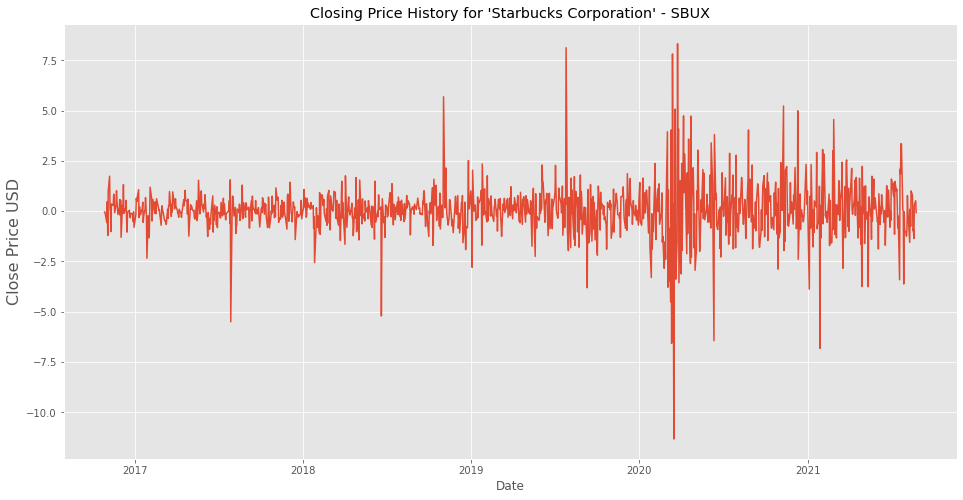

In [152]:
# Visualize closing price history
plt.figure(figsize=(16,8))
plt.title (f"Closing Price History for '{stock}' - {ticker}")
plt.plot(df2['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD', fontsize=16)
plt.savefig('static/Images/diff_'+ticker+'.png')
plt.show()

In [153]:
# TSdata_arr = df2.filter(['Close']).values
# TSdata_arr

In [154]:
# Scale the Data
scaler = MinMaxScaler(feature_range =(0,1))
scaled_data = scaler.fit_transform(TSdata_arr)
# scaled_data

In [155]:
training_data_len = math.ceil(len(TSdata_arr) * 0.75)
training_data_len

912

In [156]:
# Created scaled training dataset
train_data = scaled_data[0:training_data_len]
train_data.shape

(912, 1)

In [157]:
# Split
X_train = []
y_train = []

for i in range(ts_points, len(train_data)):
    X_train.append(train_data[i-ts_points:i,0])
    y_train.append(train_data[i,0])
    # if i <= ts_points+3:
    #     print(X_train)
    #     print(y_train)
    #     print()


In [158]:
# convert X_train and y_train to numpy arrays for LSTM
X_train, y_train = np.array(X_train), np.array(y_train)

In [159]:
print (X_train.shape)
print (y_train.shape)

(792, 120)
(792,)


In [160]:
# LSTM network expects a 3D input (No_of_Samples, number of time steps, and number of features) no_of_features = 1 (Close)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(792, 120, 1)

In [161]:
training_data_len - ts_points

792

In [162]:
# hidden_nodes = int(2/3 * (X_train.shape[1] * 1))
# print(f"The number of hidden nodes is {hidden_nodes}.")

In [163]:
# LSTM MOdel
model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
# model.add(tf.keras.layers.LSTM(50, return_sequences=False))
# model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Dense(25))
# model.add(tf.keras.layers.Dense(1))
# model.summary()


In [164]:

# # BEST FOR TESLA#
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(tf.keras.layers.LSTM(50, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(25))
model.add(tf.keras.layers.Dense(1))
model.summary()

# #model.fit(X_train, y_train, batch_size=64, epochs=50

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 120, 50)           10400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [165]:
model.compile(optimizer='adam', loss='mean_squared_error')
# model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [166]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size=64

os.makedirs("chk_points/", exist_ok=True)
chkpoint_path="chk_points/weights.{epoch}.hdf5"

# Create chk points
chkpt_callback = ModelCheckpoint(filepath=chkpoint_path,
                              verbose=1,
                              save_weights_only=True,
                              save_freq="epoch",
                              period=5)

# chkpoint_path = "chk_points/cp-{epoch:04d}.ckpt"
# chkpt_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=chkpoint_path, 
#     verbose=1, 
#     save_weights_only=True,
#     save_freq=5*batch_size)                    

# model.save_weights(chkpoint_path.format(epoch=0))    


In [167]:
# training_data_len
# scaled_data

In [168]:
# model.fit(X_train, y_train, batch_size=batch_size, epochs=50, validation_split=0.43, callbacks=[chkpt_callback])
model.fit(X_train, y_train, batch_size=64 ,epochs=30)

Epoch 1/30
13/13 [==============================] - 3s 73ms/step - loss: 0.0282
Epoch 2/30
13/13 [==============================] - 1s 74ms/step - loss: 0.0060
Epoch 3/30
13/13 [==============================] - 1s 105ms/step - loss: 0.0030
Epoch 4/30
13/13 [==============================] - 2s 142ms/step - loss: 0.0023
Epoch 5/30
13/13 [==============================] - 2s 141ms/step - loss: 0.0021
Epoch 6/30
13/13 [==============================] - 2s 135ms/step - loss: 0.0018
Epoch 7/30
13/13 [==============================] - 2s 137ms/step - loss: 0.0018
Epoch 8/30
13/13 [==============================] - 2s 153ms/step - loss: 0.0016
Epoch 9/30
13/13 [==============================] - 2s 155ms/step - loss: 0.0016
Epoch 10/30
13/13 [==============================] - 2s 138ms/step - loss: 0.0014
Epoch 11/30
13/13 [==============================] - 2s 134ms/step - loss: 0.0013
Epoch 12/30
13/13 [==============================] - 2s 136ms/step - loss: 0.0014
Epoch 13/30
13/13 [========

In [169]:
model.save('Saved_Models/Model_'+ticker+'.h5')

In [170]:
# test_data = scaled_data[training_data_len:]

# Bring in the last 'ts_points' (120 values) from training set so when X_test is used to predict , predictions have same shape as Y_test
# The for loop starts with 'ts_points' thatbmeans the resultant array will have 120 less rows
test_data = scaled_data[training_data_len-ts_points:]



In [171]:
X_test = []
y_test = TSdata_arr[training_data_len:]
for i in range(ts_points, len(test_data)):
    X_test.append(test_data[i-ts_points:i,0])


In [172]:
# convert the data to a numpy array to use it in LSTM MODEL
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],  X_test.shape[1], 1))

In [173]:
from sklearn.metrics import mean_squared_error

In [174]:
# Models predicted price for X_train
predictions_tr = model.predict(X_train)
predictions_tr = scaler.inverse_transform(predictions_tr)

y_train_tr =  scaler.inverse_transform(y_train.reshape(-1,1))
rmse_tr = math.sqrt(mean_squared_error(y_train_tr, predictions_tr))
rmse_tr

2.087966842064842

In [175]:
# Models predicted price for X_test
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [176]:
y_test.shape, predictions.shape

((303, 1), (303, 1))

In [177]:
# RMSE to check accuracy

rmse = math.sqrt(mean_squared_error(y_test, predictions))
rmse

2.3743472419229428

In [178]:
# Plot
train = TSdata_df[:training_data_len]
actual = TSdata_df[training_data_len:]
actual['Predictions'] = predictions
actual

<ipython-input-178-bb86776ae978>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual['Predictions'] = predictions


,Close,Predictions
Date,,
2020-06-12,76.379997,81.355972
2020-06-15,76.959999,80.507584
2020-06-16,77.839996,79.666397
2020-06-17,77.099998,78.995041
2020-06-18,76.309998,78.418663
...,...,...
2021-08-18,115.680000,113.022125
2021-08-19,114.320000,112.964272
2021-08-20,114.629997,112.792328


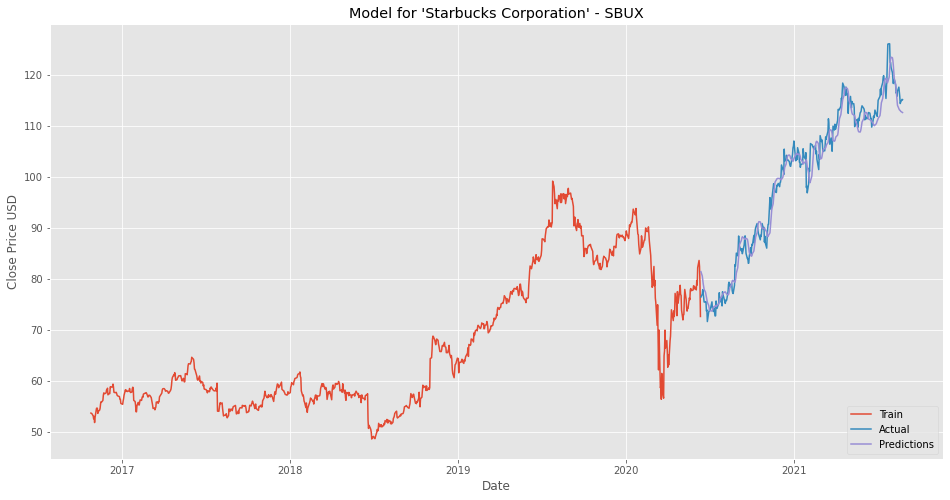

In [179]:
plt.figure(figsize=(16,8))
plt.title(f"Model for '{stock}' - {ticker}")
plt.xlabel("Date")
plt.ylabel("Close Price USD")
plt.plot(train['Close'])
plt.plot(actual[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.savefig('static/Images/'+ticker+'.png')
plt.show()

# TEST

In [180]:
# for predictions add 100 extra days to make sure it has more than ts_points to make up for missing days (weekends and holidays)

fetch_days = ts_points + 100    

sd =  today - timedelta(days=fetch_days)
sd = sd.strftime('%Y-%m-%d')

ed = today.strftime('%Y-%m-%d')
ed

next_day = (today + timedelta(days=1) ).strftime('%Y-%m-%d')
# next_day

In [181]:
# get the quote
quote = pdr.DataReader(ticker, data_source="yahoo", start=sd, end=ed)
new_df = quote.filter(['Close'])
last_n_days = ts_points
last_n_days_arr = new_df[-last_n_days:].values 

In [182]:
last_n_days_scaled = scaler.transform(last_n_days_arr)
X_test = []
X_test.append(last_n_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1],1))


In [183]:
##########################loading saved model ###############################
new_model = tf.keras.models.load_model('Saved_Models/Model_'+ticker+'.h5')

# Check its architecture
new_model.summary()
nmpred_price = new_model.predict(X_test)
nmpred_price = scaler.inverse_transform(nmpred_price)
nmpred_price = nmpred_price[0][0]
print(f"Predicted Closing price for '{stock}' on {next_day} is {nmpred_price:.4f}")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 120, 50)           10400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________
Predicted Closing price for 'Starbucks Corporation' on 2021-10-26 is 113.5016


In [184]:
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
pred_price = pred_price[0][0]
print(f"Predicted Closing price for '{stock}' on {next_day} is {pred_price:.4f}")

Predicted Closing price for 'Starbucks Corporation' on 2021-10-26 is 113.5016


In [185]:
# verify
d1 = today - timedelta(days=5)
d1 = d1.strftime('%Y-%m-%d')

quote2 = pdr.DataReader(ticker, data_source="yahoo", start=d1)
quote2

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-10-20,115.110001,112.709999,113.059998,113.860001,7645200,113.860001
2021-10-21,114.559998,113.610001,113.930000,114.440002,3684300,114.440002
2021-10-22,114.980003,114.070000,114.410004,114.550003,3396000,114.550003
2021-10-25,114.879700,113.355003,114.739998,114.709999,4148628,114.709999
